In [1]:
%load_ext dotenv
%dotenv

import tqdm
from flax import linen as nn
import jax
from typing import Dict, Callable, Sequence, Any, Union
from dataclasses import field
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from flax import struct                # Flax dataclasses
import time
import os
from datetime import datetime
from flax.training import orbax_utils
import functools

2024-07-06 00:06:37.689572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Initialization

In [2]:
# Some Optimizations
import ctypes

_libcudart = ctypes.CDLL("libcudart.so")
# Set device limit on the current device
# cudaLimitMaxL2FetchGranularity = 0x05
pValue = ctypes.cast((ctypes.c_int * 1)(), ctypes.POINTER(ctypes.c_int))
_libcudart.cudaDeviceSetLimit(ctypes.c_int(0x05), ctypes.c_int(128))
_libcudart.cudaDeviceGetLimit(pValue, ctypes.c_int(0x05))
assert pValue.contents.value == 128
tf.compat.v1.ConfigProto.force_gpu_compatible = True

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1720204602.207861  452115 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720204602.233454  452115 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720204602.233606  452115 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1720204602.234817  452115 cuda_executor.cc:1020] successful NUMA node read from SysFS ha

In [3]:
normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(tf.cast(denormalizeImage(imgs[i, :, :, :]), tf.uint8))
        plt.axis("off")
    plt.show()

class RandomClass():
    def __init__(self, rng: jax.random.PRNGKey):
        self.rng = rng

    def get_random_key(self):
        self.rng, subkey = jax.random.split(self.rng)
        return subkey
    
    def get_sigmas(self, steps):
        return jnp.tan(self.theta_min + steps * (self.theta_max - self.theta_min)) / self.kappa

    def reset_random_key(self):
        self.rng = jax.random.PRNGKey(42)

class MarkovState(struct.PyTreeNode):
    pass

class RandomMarkovState(MarkovState):
    rng: jax.random.PRNGKey

    def get_random_key(self):
        rng, subkey = jax.random.split(self.rng)
        return RandomMarkovState(rng), subkey

# Data Pipeline

In [4]:
def get_dataset(data_name="celeb_a", batch_size=64, image_scale=256):
    def augmenter(image_scale=256, method="area"):
        @tf.function()
        def augment(sample):
            image = (
                tf.cast(sample["image"], tf.float32) - 127.5
            ) / 127.5
            image = tf.image.resize(
                image, [image_scale, image_scale], method=method, antialias=True
            )
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_contrast(image, 0.999, 1.05)
            image = tf.image.random_brightness(image, 0.2)

            image = tf.clip_by_value(image, -1.0, 1.0)
            return image
        return augment

    # Load CelebA Dataset
    data: tf.data.Dataset = tfds.load(data_name, split="all", shuffle_files=True)
    final_data = (
        data
        .cache()  # Cache after augmenting to avoid recomputation
        # .prefetch(tf.data.experimental.AUTOTUNE)
        # .batch(128, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            augmenter(image_scale, method="area"),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .repeat()  # Repeats the dataset indefinitely
        # .unbatch()
        .shuffle(4096)  # Ensure this is adequate for your dataset size
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
    ).as_numpy_iterator()
    return final_data, len(data)


# Noise Samplers

In [5]:
from flaxdiff.schedulers import CosineNoiseSchedule, NoiseScheduler, GeneralizedNoiseScheduler, KarrasVENoiseScheduler, EDMNoiseScheduler
from flaxdiff.predictors import VPredictionTransform, EpsilonPredictionTransform, DiffusionPredictionTransform, DirectPredictionTransform, KarrasPredictionTransform

# Modeling

## Metrics

## Callbacks

## Model Generator

## Main Model

In [7]:
from flaxdiff.models.simple_unet import l2norm, ConvLayer, TimeEmbedding, TimeProjection, Upsample, Downsample, ResidualBlock, PixelShuffle
from flaxdiff.models.simple_unet import FourierEmbedding, kernel_init, AttentionBlock

class Unet(nn.Module):
    emb_features:int=64*4,
    feature_depths:list=[64, 128, 256, 512],
    attention_configs:list=[{"heads":8}, {"heads":8}, {"heads":8}, {"heads":8}],
    num_res_blocks:int=2,
    num_middle_res_blocks:int=1,
    activation:Callable = jax.nn.mish
    norm_groups:int=8

    @nn.compact
    def __call__(self, x, temb):
        # print("embedding features", self.emb_features)
        temb = FourierEmbedding(features=self.emb_features)(temb)
        temb = TimeProjection(features=self.emb_features)(temb)
        # print("time embedding", temb.shape)
        feature_depths = self.feature_depths
        attention_configs = self.attention_configs

        conv_type = up_conv_type = down_conv_type = "conv"
        middle_conv_type = "separable"

        x = ConvLayer(
            conv_type,
            features=self.feature_depths[0],
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_init=kernel_init(1.0)
        )(x)
        downs = [x]

        # Downscaling blocks
        for i, (dim_out, attention_config) in enumerate(zip(feature_depths, attention_configs)):
            dim_in = x.shape[-1]
            # dim_in = dim_out
            for j in range(self.num_res_blocks):
                x = ResidualBlock(
                    down_conv_type,
                    name=f"down_{i}_residual_{j}",
                    features=dim_in,
                    kernel_init=kernel_init(1.0),
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_in // attention_config['heads'],
                                       name=f"down_{i}_attention_{j}")(x)
                # print("down residual for feature level", i, "is of shape", x.shape, "features", dim_in)
                downs.append(x)
            if i != len(feature_depths) - 1:
                # print("Downsample", i, x.shape)
                x = Downsample(
                    features=dim_out,
                    scale=2,
                    activation=self.activation,
                    name=f"down_{i}_downsample"
                )(x)

        # Middle Blocks
        middle_dim_out = self.feature_depths[-1]
        middle_attention = self.attention_configs[-1]
        # x = nn.GroupNorm(8)(x)
        # x = ConvLayer(
        #     conv_type,
        #     features=middle_dim_out,
        #     kernel_size=(3, 3),
        #     strides=(1, 1),
        #     kernel_init=kernel_init(1.0),
        #     name="middle_conv"
        # )(x)
        for j in range(self.num_middle_res_blocks):
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res1_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)
            if middle_attention is not None and j == self.num_middle_res_blocks - 1:   # Apply attention only on the last block
                x = AttentionBlock(heads=attention_config['heads'], 
                                   dim_head=middle_dim_out // attention_config['heads'],
                                   use_linear_attention=False, name=f"middle_attention_{j}")(x)
            x = ResidualBlock(
                middle_conv_type,
                name=f"middle_res2_{j}",
                features=middle_dim_out,
                kernel_init=kernel_init(1.0),
                kernel_size=(3, 3),
                strides=(1, 1),
                activation=self.activation,
                norm_groups=self.norm_groups
            )(x, temb)

        # Upscaling Blocks
        for i, (dim_out, attention_config) in enumerate(zip(reversed(feature_depths), reversed(attention_configs))):
            # print("Upscaling", i, "features", dim_out)
            for j in range(self.num_res_blocks):
                x = jnp.concatenate([x, downs.pop()], axis=-1)
                # print("concat==> ", i, "concat", x.shape)
                kernel_size = (1 + 2 * (j + 1), 1 + 2 * (j + 1))
                # kernel_size = (3, 3)
                x = ResidualBlock(
                    up_conv_type if j == 0 else "separable",
                    name=f"up_{i}_residual_{j}",
                    features=dim_out,
                    kernel_init=kernel_init(1.0),
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    activation=self.activation,
                    norm_groups=self.norm_groups
                )(x, temb)
                if attention_config is not None and j == self.num_res_blocks - 1:   # Apply attention only on the last block
                    x = AttentionBlock(heads=attention_config['heads'], 
                                       dim_head=dim_out // attention_config['heads'],
                                       name=f"up_{i}_attention_{j}")(x)
            # print("Upscaling ", i, x.shape)
            if i != len(feature_depths) - 1:
                x = Upsample(
                    features=feature_depths[-i],
                    scale=2,
                    activation=self.activation,
                    name=f"up_{i}_upsample"
                )(x)

        # x = nn.GroupNorm(8)(x)
        # x = ConvLayer(
        #     conv_type,
        #     features=self.feature_depths[0],
        #     kernel_size=(3, 3),
        #     strides=(1, 1),
        #     kernel_init=kernel_init(0.0)
        # )(x)
    
        x = jnp.concatenate([x, downs.pop()], axis=-1)

        x = ResidualBlock(
            conv_type,
            name="final_residual",
            features=self.feature_depths[0],
            kernel_init=kernel_init(1.0),
            kernel_size=(3,3),
            strides=(1, 1),
            activation=self.activation,
            norm_groups=self.norm_groups
        )(x, temb)

        x = nn.GroupNorm(self.norm_groups)(x)
        x = self.activation(x)

        noise_out = ConvLayer(
            conv_type,
            features=3,
            kernel_size=(3, 3),
            strides=(1, 1),
            # activation=jax.nn.mish
            kernel_init=kernel_init(0.0)
        )(x)
        return noise_out#, attentions

# Training

In [8]:
BATCH_SIZE = 16
IMAGE_SIZE = 64

cosine_schedule = CosineNoiseSchedule(1000, beta_end=1)
karas_ve_schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
edm_schedule = EDMNoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)

In [12]:
import orbax.checkpoint


@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss') # type: ignore

class ModelState():
    model: nn.Module
    params: dict
    noise_schedule: NoiseScheduler
    model_output_transform: DiffusionPredictionTransform

# Define the TrainState with EMA parameters
class TrainState(train_state.TrainState):
    rngs: jax.random.PRNGKey
    ema_params: dict

    def get_random_key(self):
        rngs, subkey = jax.random.split(self.rngs)
        return self.replace(rngs=rngs), subkey

    def apply_ema(self, decay: float=0.999):
        new_ema_params = jax.tree_util.tree_map(
            lambda ema, param: decay * ema + (1 - decay) * param,
            self.ema_params,
            self.params,
        )
        return self.replace(ema_params=new_ema_params)

class DiffusionTrainer:
    state : TrainState
    best_state : TrainState
    best_loss : float
    model : nn.Module
    noise_schedule : NoiseScheduler
    model_output_transform:DiffusionPredictionTransform
    ema_decay:float = 0.999
    
    def __init__(self, 
                 model:nn.Module, 
                 optimizer: optax.GradientTransformation,
                 noise_schedule:NoiseScheduler,
                 rngs:jax.random.PRNGKey,
                 train_state:TrainState=None,
                 name:str="Diffusion",
                 load_from_checkpoint:bool=False,
                 param_transforms:Callable=None,
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform(),
                 loss_fn=optax.l2_loss
                 ):
        self.model = model
        self.noise_schedule = noise_schedule
        self.name = name
        self.model_output_transform = model_output_transform
        self.loss_fn = loss_fn

        checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=4, create=True)
        self.checkpointer = orbax.checkpoint.CheckpointManager(self.checkpoint_path(), checkpointer, options)

        if load_from_checkpoint:
            old_state, old_best_state = self.load()
        else:
            old_state, old_best_state = None, None

        if train_state == None:
            self.init_state(optimizer, rngs, existing_state=old_state, existing_best_state=old_best_state, model=model, param_transforms=param_transforms)
        else:
            self.state = train_state
            self.best_state = train_state
            self.best_loss = 1e9

    def init_state(self, 
                   optimizer: optax.GradientTransformation, 
                   rngs:jax.random.PRNGKey,
                   existing_state:dict=None,
                   existing_best_state:dict=None,
                   model:nn.Module=None,
                     param_transforms:Callable=None,
                   ):
        inp = jnp.ones((1, 64, 64, 3))
        temb = jnp.ones((1,))
        rngs, subkey = jax.random.split(rngs)

        if existing_state == None:
            params = model.init(subkey, inp, temb)
            existing_state = {"params":params, "ema_params":params}

        if param_transforms is not None:
            params = param_transforms(params)
        self.best_loss = 1e9
        self.state = TrainState.create(
            apply_fn=model.apply,
            params=existing_state['params'],
            ema_params=existing_state['ema_params'],
            tx=optimizer,
            rngs=rngs,
        )
        if existing_best_state is not None:
            self.best_state = self.state.replace(params=existing_best_state['params'], ema_params=existing_best_state['ema_params'])
        else:
            self.best_state = self.state

    def checkpoint_path(self):
        experiment_name = self.name
        path = os.path.join(os.path.abspath('./checkpoints'), experiment_name)
        if not os.path.exists(path):
            os.makedirs(path)
        return path

    def load(self):
        step = self.checkpointer.latest_step()
        print("Loading model from checkpoint", step)
        ckpt = self.checkpointer.restore(step)
        state = ckpt['state']
        best_state = ckpt['best_state']
        # Convert the state to a TrainState
        self.best_loss = ckpt['best_loss']
        print(f"Loaded model from checkpoint at step {step}", ckpt['best_loss'])
        return state, best_state

    def save(self, epoch=0):
        print(f"Saving model at epoch {epoch}")
        # filename = os.path.join(self.checkpoint_path(), f'model_{epoch}' if not best else 'best_model')
        ckpt = {
            'model': self.model,
            'state': self.state,
            'best_state': self.best_state,
            'best_loss': self.best_loss
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpointer.save(epoch, ckpt, save_kwargs={'save_args': save_args})

    def summary(self):
        inp = jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, 3))
        temb = jnp.ones((1,))
        print(self.model.tabulate(jax.random.key(0), inp, temb, console_kwargs={"width": 200, "force_jupyter":True, }))

    def _define_train_step(self):
        noise_schedule = self.noise_schedule
        model = self.model
        model_output_transform = self.model_output_transform
        loss_fn = self.loss_fn
        @jax.jit
        def train_step(state:TrainState, batch):
            """Train for a single step."""
            images = batch
            noise_level, state = noise_schedule.generate_timesteps(images.shape[0], state)
            state, rngs = state.get_random_key()
            noise:jax.Array = jax.random.normal(rngs, shape=images.shape)
            rates = noise_schedule.get_rates(noise_level)
            noisy_images, c_in, expected_output = model_output_transform.forward_diffusion(images, noise, rates)
            def model_loss(params):
                preds = model.apply(params, *noise_schedule.transform_inputs(noisy_images*c_in, noise_level))
                preds = model_output_transform.pred_transform(noisy_images, preds, rates)
                nloss = loss_fn(preds, expected_output)
                # nloss = jnp.mean(nloss, axis=1)
                nloss *= noise_schedule.get_weights(noise_level)
                nloss = jnp.mean(nloss)
                loss = nloss
                return loss
            loss, grads = jax.value_and_grad(model_loss)(state.params)
            state = state.apply_gradients(grads=grads) 
            state = state.apply_ema(self.ema_decay)
            return state, loss
        return train_step
    
    def _define_compute_metrics(self):
        @jax.jit
        def compute_metrics(state:TrainState, expected, pred):
            loss = jnp.mean(jnp.square(pred - expected))
            metric_updates = state.metrics.single_from_model_output(loss=loss)
            metrics = state.metrics.merge(metric_updates)
            state = state.replace(metrics=metrics)
            return state
        return compute_metrics

    def fit(self, data, steps_per_epoch, epochs):
        data = iter(data)
        train_step = self._define_train_step()
        compute_metrics = self._define_compute_metrics()
        state = self.state
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()
            epoch_loss = 0
            with tqdm.tqdm(total=steps_per_epoch, desc=f'\t\tEpoch {epoch+1}', ncols=100, unit='step') as pbar:
                for i in range(steps_per_epoch):
                    batch = next(data)
                    state, loss = train_step(state, batch)
                    epoch_loss += loss
                    if i % 100 == 0:
                        pbar.set_postfix(loss=f'{loss:.4f}')
                        pbar.update(100)
            end_time = time.time()
            self.state = state
            total_time = end_time - start_time
            avg_time_per_step = total_time / steps_per_epoch
            avg_loss = epoch_loss / steps_per_epoch
            if avg_loss < self.best_loss:
                self.best_loss = avg_loss
                self.best_state = state
                self.save(epoch)
            print(f"\n\tEpoch {epoch+1} completed. Avg Loss: {avg_loss}, Time: {total_time:.2f}s, Best Loss: {self.best_loss}")
        self.save(epochs)
        return self.state


In [38]:
# experiment_name = "{name}_{date}".format(
#     name="Diffusion_SDE_VE", date=datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
# )
experiment_name = 'Diffusion_SDE_VE_2024-07-06_00:19:55'
print("Experiment_Name:", experiment_name)
unet = Unet(emb_features=256, 
            feature_depths=[64, 128, 256, 512],
            attention_configs=[{"heads":4}, {"heads":4}, {"heads":4}, {"heads":4}, {"heads":4}],
            num_res_blocks=2,
            num_middle_res_blocks=1
)

data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
batches = datalen // BATCH_SIZE

# Suggested configurations
total_epochs = 1000
steps_per_epoch = batches
init_value = 1e-6
peak_value = 2e-4
warmup_steps = steps_per_epoch * 5
decay_steps = total_epochs * steps_per_epoch - warmup_steps
end_value = 1e-6
exponent = 1.0

# # Create the learning rate schedule
# learning_rate_schedule = optax.warmup_cosine_decay_schedule(
#     init_value=init_value,
#     peak_value=peak_value,
#     warmup_steps=warmup_steps,
#     decay_steps=decay_steps,
#     end_value=end_value,
#     exponent=exponent
# )

# solver = optax.adamw(learning_rate=learning_rate_schedule)
# solver = optax.radam(2e-4)
solver = optax.adam(2e-4)

# solver = optax.lookahead(solver, sync_period=6, slow_step_size=0.5)
# params_transform = lambda x: optax.LookaheadParams.init_synced(x)

trainer = DiffusionTrainer(unet, optimizer=solver, 
                           noise_schedule=edm_schedule,
                           rngs=jax.random.PRNGKey(4), 
                           name=experiment_name,
                           model_output_transform=KarrasPredictionTransform(sigma_data=edm_schedule.sigma_data),
                        #    train_state=trainer.best_state,
                        #    loss_fn=lambda x, y: jnp.abs(x - y),
                            # param_transforms=params_transform,
                           load_from_checkpoint=True,
                           )
#trainer.summary()

Experiment_Name: Diffusion_SDE_VE_2024-07-06_00:19:55
Loading model from checkpoint 2000
Loaded model from checkpoint at step 2000 0.091221236


In [37]:
oldtrainer = trainer

In [ ]:
trainer.summary()

In [20]:
data, datalen = get_dataset("oxford_flowers102", batch_size=BATCH_SIZE, image_scale=IMAGE_SIZE)
final_state = trainer.fit(data, batches, epochs=2000)

		Epoch 1940: 600step [00:22, 26.42step/s, loss=0.1071]                                             



	Epoch 1940 completed. Avg Loss: 0.09434887766838074, Time: 22.71s, Best Loss: 0.09160102903842926

Epoch 1941/2000


		Epoch 1941: 600step [00:21, 27.95step/s, loss=0.1155]                                             



	Epoch 1941 completed. Avg Loss: 0.09250590950250626, Time: 21.47s, Best Loss: 0.09160102903842926

Epoch 1942/2000


		Epoch 1942: 600step [00:21, 27.96step/s, loss=0.0866]                                             



	Epoch 1942 completed. Avg Loss: 0.09293313324451447, Time: 21.46s, Best Loss: 0.09160102903842926

Epoch 1943/2000


		Epoch 1943: 600step [00:21, 27.97step/s, loss=0.0876]                                             



	Epoch 1943 completed. Avg Loss: 0.09338673204183578, Time: 21.46s, Best Loss: 0.09160102903842926

Epoch 1944/2000


		Epoch 1944: 600step [00:21, 27.97step/s, loss=0.0925]                                             



	Epoch 1944 completed. Avg Loss: 0.09262797236442566, Time: 21.45s, Best Loss: 0.09160102903842926

Epoch 1945/2000


		Epoch 1945: 600step [00:21, 27.97step/s, loss=0.0796]                                             



	Epoch 1945 completed. Avg Loss: 0.0928560346364975, Time: 21.45s, Best Loss: 0.09160102903842926

Epoch 1946/2000


		Epoch 1946: 600step [00:21, 27.78step/s, loss=0.0848]                                             



	Epoch 1946 completed. Avg Loss: 0.09400678426027298, Time: 21.60s, Best Loss: 0.09160102903842926

Epoch 1947/2000


		Epoch 1947: 600step [00:21, 27.95step/s, loss=0.0899]                                             



	Epoch 1947 completed. Avg Loss: 0.09239151328802109, Time: 21.47s, Best Loss: 0.09160102903842926

Epoch 1948/2000


		Epoch 1948: 600step [00:21, 27.94step/s, loss=0.1151]                                             



	Epoch 1948 completed. Avg Loss: 0.09264709800481796, Time: 21.48s, Best Loss: 0.09160102903842926

Epoch 1949/2000


		Epoch 1949: 600step [00:21, 27.85step/s, loss=0.0664]                                             


Saving model at epoch 1948

	Epoch 1949 completed. Avg Loss: 0.09122123569250107, Time: 21.55s, Best Loss: 0.09122123569250107

Epoch 1950/2000


		Epoch 1950: 600step [00:21, 27.98step/s, loss=0.0769]                                             



	Epoch 1950 completed. Avg Loss: 0.0926654264330864, Time: 21.45s, Best Loss: 0.09122123569250107

Epoch 1951/2000


		Epoch 1951: 600step [00:21, 27.79step/s, loss=0.0971]                                             



	Epoch 1951 completed. Avg Loss: 0.09312169253826141, Time: 21.60s, Best Loss: 0.09122123569250107

Epoch 1952/2000


		Epoch 1952: 600step [00:21, 27.97step/s, loss=0.0892]                                             



	Epoch 1952 completed. Avg Loss: 0.0930522158741951, Time: 21.45s, Best Loss: 0.09122123569250107

Epoch 1953/2000


		Epoch 1953: 600step [00:22, 27.01step/s, loss=0.0792]                                             



	Epoch 1953 completed. Avg Loss: 0.09340031445026398, Time: 22.21s, Best Loss: 0.09122123569250107

Epoch 1954/2000


		Epoch 1954: 600step [00:21, 27.48step/s, loss=0.0916]                                             



	Epoch 1954 completed. Avg Loss: 0.09289424866437912, Time: 21.84s, Best Loss: 0.09122123569250107

Epoch 1955/2000


		Epoch 1955: 600step [00:21, 27.53step/s, loss=0.0992]                                             



	Epoch 1955 completed. Avg Loss: 0.09191833436489105, Time: 21.80s, Best Loss: 0.09122123569250107

Epoch 1956/2000


		Epoch 1956: 600step [00:21, 27.31step/s, loss=0.0929]                                             



	Epoch 1956 completed. Avg Loss: 0.0926123708486557, Time: 21.97s, Best Loss: 0.09122123569250107

Epoch 1957/2000


		Epoch 1957: 600step [00:21, 27.64step/s, loss=0.1047]                                             



	Epoch 1957 completed. Avg Loss: 0.09392254054546356, Time: 21.71s, Best Loss: 0.09122123569250107

Epoch 1958/2000


		Epoch 1958: 600step [00:22, 27.12step/s, loss=0.0971]                                             



	Epoch 1958 completed. Avg Loss: 0.09315788000822067, Time: 22.13s, Best Loss: 0.09122123569250107

Epoch 1959/2000


		Epoch 1959: 600step [00:23, 25.91step/s, loss=0.1169]                                             



	Epoch 1959 completed. Avg Loss: 0.09295763820409775, Time: 23.16s, Best Loss: 0.09122123569250107

Epoch 1960/2000


		Epoch 1960: 600step [00:23, 25.80step/s, loss=0.0964]                                             



	Epoch 1960 completed. Avg Loss: 0.0924694687128067, Time: 23.25s, Best Loss: 0.09122123569250107

Epoch 1961/2000


		Epoch 1961: 600step [00:22, 26.82step/s, loss=0.1211]                                             



	Epoch 1961 completed. Avg Loss: 0.0928744524717331, Time: 22.38s, Best Loss: 0.09122123569250107

Epoch 1962/2000


		Epoch 1962: 600step [00:21, 27.50step/s, loss=0.0961]                                             



	Epoch 1962 completed. Avg Loss: 0.09385368973016739, Time: 21.82s, Best Loss: 0.09122123569250107

Epoch 1963/2000


		Epoch 1963: 600step [00:22, 26.44step/s, loss=0.1329]                                             



	Epoch 1963 completed. Avg Loss: 0.09209564328193665, Time: 22.69s, Best Loss: 0.09122123569250107

Epoch 1964/2000


		Epoch 1964: 600step [00:22, 27.17step/s, loss=0.1191]                                             



	Epoch 1964 completed. Avg Loss: 0.09332973510026932, Time: 22.08s, Best Loss: 0.09122123569250107

Epoch 1965/2000


		Epoch 1965: 600step [00:21, 27.28step/s, loss=0.1025]                                             



	Epoch 1965 completed. Avg Loss: 0.09279324859380722, Time: 21.99s, Best Loss: 0.09122123569250107

Epoch 1966/2000


		Epoch 1966: 600step [00:21, 27.55step/s, loss=0.0960]                                             



	Epoch 1966 completed. Avg Loss: 0.09314973652362823, Time: 21.78s, Best Loss: 0.09122123569250107

Epoch 1967/2000


		Epoch 1967: 600step [00:23, 25.71step/s, loss=0.0956]                                             



	Epoch 1967 completed. Avg Loss: 0.09350484609603882, Time: 23.34s, Best Loss: 0.09122123569250107

Epoch 1968/2000


		Epoch 1968: 600step [00:21, 27.37step/s, loss=0.0857]                                             



	Epoch 1968 completed. Avg Loss: 0.09245267510414124, Time: 21.93s, Best Loss: 0.09122123569250107

Epoch 1969/2000


		Epoch 1969: 600step [00:22, 26.75step/s, loss=0.0950]                                             



	Epoch 1969 completed. Avg Loss: 0.09323622286319733, Time: 22.43s, Best Loss: 0.09122123569250107

Epoch 1970/2000


		Epoch 1970: 600step [00:21, 27.76step/s, loss=0.0801]                                             



	Epoch 1970 completed. Avg Loss: 0.09257423877716064, Time: 21.62s, Best Loss: 0.09122123569250107

Epoch 1971/2000


		Epoch 1971: 600step [00:21, 27.37step/s, loss=0.0869]                                             



	Epoch 1971 completed. Avg Loss: 0.09163910150527954, Time: 21.92s, Best Loss: 0.09122123569250107

Epoch 1972/2000


		Epoch 1972: 600step [00:22, 27.10step/s, loss=0.1234]                                             



	Epoch 1972 completed. Avg Loss: 0.0920034721493721, Time: 22.14s, Best Loss: 0.09122123569250107

Epoch 1973/2000


		Epoch 1973: 600step [00:22, 26.94step/s, loss=0.1260]                                             



	Epoch 1973 completed. Avg Loss: 0.09314941614866257, Time: 22.27s, Best Loss: 0.09122123569250107

Epoch 1974/2000


		Epoch 1974: 600step [00:22, 26.85step/s, loss=0.0785]                                             



	Epoch 1974 completed. Avg Loss: 0.09203878790140152, Time: 22.34s, Best Loss: 0.09122123569250107

Epoch 1975/2000


		Epoch 1975: 600step [00:22, 27.25step/s, loss=0.1088]                                             



	Epoch 1975 completed. Avg Loss: 0.0930892750620842, Time: 22.02s, Best Loss: 0.09122123569250107

Epoch 1976/2000


		Epoch 1976: 600step [00:22, 27.08step/s, loss=0.1045]                                             



	Epoch 1976 completed. Avg Loss: 0.09204603731632233, Time: 22.16s, Best Loss: 0.09122123569250107

Epoch 1977/2000


		Epoch 1977: 600step [00:22, 26.75step/s, loss=0.1115]                                             



	Epoch 1977 completed. Avg Loss: 0.09201757609844208, Time: 22.43s, Best Loss: 0.09122123569250107

Epoch 1978/2000


		Epoch 1978: 600step [00:22, 26.82step/s, loss=0.0721]                                             



	Epoch 1978 completed. Avg Loss: 0.09314733743667603, Time: 22.37s, Best Loss: 0.09122123569250107

Epoch 1979/2000


		Epoch 1979: 600step [00:22, 26.65step/s, loss=0.1007]                                             



	Epoch 1979 completed. Avg Loss: 0.09297390282154083, Time: 22.52s, Best Loss: 0.09122123569250107

Epoch 1980/2000


		Epoch 1980: 600step [00:21, 27.62step/s, loss=0.0907]                                             



	Epoch 1980 completed. Avg Loss: 0.09394237399101257, Time: 21.73s, Best Loss: 0.09122123569250107

Epoch 1981/2000


		Epoch 1981: 600step [00:22, 26.64step/s, loss=0.0891]                                             



	Epoch 1981 completed. Avg Loss: 0.09231515973806381, Time: 22.52s, Best Loss: 0.09122123569250107

Epoch 1982/2000


		Epoch 1982: 600step [00:22, 27.20step/s, loss=0.0770]                                             



	Epoch 1982 completed. Avg Loss: 0.09245529770851135, Time: 22.06s, Best Loss: 0.09122123569250107

Epoch 1983/2000


		Epoch 1983: 600step [00:22, 27.02step/s, loss=0.0972]                                             



	Epoch 1983 completed. Avg Loss: 0.09224499017000198, Time: 22.21s, Best Loss: 0.09122123569250107

Epoch 1984/2000


		Epoch 1984: 600step [00:22, 27.20step/s, loss=0.0666]                                             



	Epoch 1984 completed. Avg Loss: 0.09243276715278625, Time: 22.06s, Best Loss: 0.09122123569250107

Epoch 1985/2000


		Epoch 1985: 600step [00:21, 27.30step/s, loss=0.0884]                                             



	Epoch 1985 completed. Avg Loss: 0.09278149157762527, Time: 21.98s, Best Loss: 0.09122123569250107

Epoch 1986/2000


		Epoch 1986: 600step [00:21, 27.66step/s, loss=0.1209]                                             



	Epoch 1986 completed. Avg Loss: 0.09297675639390945, Time: 21.70s, Best Loss: 0.09122123569250107

Epoch 1987/2000


		Epoch 1987: 600step [00:21, 27.34step/s, loss=0.1008]                                             



	Epoch 1987 completed. Avg Loss: 0.0923047885298729, Time: 21.95s, Best Loss: 0.09122123569250107

Epoch 1988/2000


		Epoch 1988: 600step [00:21, 27.51step/s, loss=0.0872]                                             



	Epoch 1988 completed. Avg Loss: 0.0925532653927803, Time: 21.81s, Best Loss: 0.09122123569250107

Epoch 1989/2000


		Epoch 1989: 600step [00:21, 27.33step/s, loss=0.1169]                                             



	Epoch 1989 completed. Avg Loss: 0.09229550510644913, Time: 21.96s, Best Loss: 0.09122123569250107

Epoch 1990/2000


		Epoch 1990: 600step [00:22, 27.14step/s, loss=0.0951]                                             



	Epoch 1990 completed. Avg Loss: 0.09162714332342148, Time: 22.11s, Best Loss: 0.09122123569250107

Epoch 1991/2000


		Epoch 1991: 600step [00:21, 27.50step/s, loss=0.1020]                                             



	Epoch 1991 completed. Avg Loss: 0.09287172555923462, Time: 21.82s, Best Loss: 0.09122123569250107

Epoch 1992/2000


		Epoch 1992: 600step [00:21, 27.50step/s, loss=0.1002]                                             



	Epoch 1992 completed. Avg Loss: 0.09326120465993881, Time: 21.82s, Best Loss: 0.09122123569250107

Epoch 1993/2000


		Epoch 1993: 600step [00:22, 27.11step/s, loss=0.1189]                                             



	Epoch 1993 completed. Avg Loss: 0.09291895478963852, Time: 22.13s, Best Loss: 0.09122123569250107

Epoch 1994/2000


		Epoch 1994: 600step [00:22, 26.71step/s, loss=0.0643]                                             



	Epoch 1994 completed. Avg Loss: 0.0930200070142746, Time: 22.46s, Best Loss: 0.09122123569250107

Epoch 1995/2000


		Epoch 1995: 600step [00:21, 27.32step/s, loss=0.0974]                                             



	Epoch 1995 completed. Avg Loss: 0.09171885997056961, Time: 21.97s, Best Loss: 0.09122123569250107

Epoch 1996/2000


		Epoch 1996: 600step [00:21, 27.34step/s, loss=0.1065]                                             



	Epoch 1996 completed. Avg Loss: 0.09257925301790237, Time: 21.94s, Best Loss: 0.09122123569250107

Epoch 1997/2000


		Epoch 1997: 600step [00:22, 27.21step/s, loss=0.0806]                                             



	Epoch 1997 completed. Avg Loss: 0.09220738708972931, Time: 22.05s, Best Loss: 0.09122123569250107

Epoch 1998/2000


		Epoch 1998: 600step [00:21, 27.31step/s, loss=0.1054]                                             



	Epoch 1998 completed. Avg Loss: 0.09254889190196991, Time: 21.97s, Best Loss: 0.09122123569250107

Epoch 1999/2000


		Epoch 1999: 600step [00:22, 26.79step/s, loss=0.1144]                                             



	Epoch 1999 completed. Avg Loss: 0.09352470934391022, Time: 22.40s, Best Loss: 0.09122123569250107

Epoch 2000/2000


		Epoch 2000: 600step [00:22, 26.79step/s, loss=0.1140]                                             



	Epoch 2000 completed. Avg Loss: 0.09305761009454727, Time: 22.40s, Best Loss: 0.09122123569250107
Saving model at epoch 2000


In [21]:
from flaxdiff.utils import clip_images

def clip_images(images, clip_min=-1, clip_max=1):
    return jnp.clip(images, clip_min, clip_max)
    
class DiffusionSampler():
    model:nn.Module
    noise_schedule:NoiseScheduler
    params:dict
    model_output_transform:DiffusionPredictionTransform

    def __init__(self, model:nn.Module, params:dict,  
                 noise_schedule:NoiseScheduler, 
                 model_output_transform:DiffusionPredictionTransform=EpsilonPredictionTransform()):
        self.model = model
        self.noise_schedule = noise_schedule
        self.params = params
        self.model_output_transform = model_output_transform

        @jax.jit
        def sample_model(x_t, t):
            rates = self.noise_schedule.get_rates(t)
            c_in = self.model_output_transform.get_input_scale(rates)
            model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(x_t * c_in, t))
            x_0, eps = self.model_output_transform(x_t, model_output, t, self.noise_schedule)
            return x_0, eps, model_output
        
        self.sample_model = sample_model

    # Used to sample from the diffusion model
    def sample_step(self, current_samples:jnp.ndarray, current_step, next_step=None, state:MarkovState=None) -> tuple[jnp.ndarray, MarkovState]:
        # First clip the noisy images
        # pred_images = clip_images(pred_images)
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        pred_images, pred_noise, _ = self.sample_model(current_samples, current_step)
        # plotImages(pred_images)
        new_samples, state =  self.take_next_step(current_samples=current_samples, reconstructed_samples=pred_images, 
                             pred_noise=pred_noise, current_step=current_step, next_step=next_step, state=state)
        return new_samples, state

    def take_next_step(self, current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=1) -> tuple[jnp.ndarray, RandomMarkovState]:
        # estimate the q(x_{t-1} | x_t, x_0). 
        # pred_images is x_0, noisy_images is x_t, steps is t
        return NotImplementedError
    
    def scale_steps(self, steps):
        scale_factor = self.noise_schedule.max_timesteps / 1000
        return steps * scale_factor

    def get_steps(self, start_step, end_step, diffusion_steps):
        step_range = start_step - end_step
        if diffusion_steps is None or diffusion_steps == 0:
            diffusion_steps = start_step - end_step
        diffusion_steps = min(diffusion_steps, step_range)
        steps = jnp.linspace(end_step, start_step, diffusion_steps, dtype=jnp.int16)[::-1]
        return steps
    
    def get_initial_samples(self, num_images, rngs:jax.random.PRNGKey, start_step):
        start_step = self.scale_steps(start_step)
        alpha_n, sigma_n = self.noise_schedule.get_rates(start_step)
        variance = jnp.sqrt(alpha_n ** 2 + sigma_n ** 2) 
        return jax.random.normal(rngs, (num_images, IMAGE_SIZE, IMAGE_SIZE, 3)) * variance

    def generate_images(self,
                        num_images=16, 
                        diffusion_steps=1000, 
                        start_step:int = None,
                        end_step:int = 0,
                        steps_override=None,
                        priors=None, 
                        rngstate:RandomMarkovState=RandomMarkovState(jax.random.PRNGKey(42))) -> jnp.ndarray:
        if priors is None:
            rngstate, newrngs = rngstate.get_random_key()
            samples = self.get_initial_samples(num_images, newrngs, start_step)
        else:
            print("Using priors")
            samples = priors

        @jax.jit
        def sample_step(state:RandomMarkovState, samples, current_step, next_step):
            samples, state = self.sample_step(current_samples=samples,
                                              current_step=current_step, 
                                              state=state, next_step=next_step)
            return samples, state

        if start_step is None:
            start_step = self.noise_schedule.max_timesteps

        if steps_override is not None:
            steps = steps_override
        else:
            steps = self.get_steps(start_step, end_step, diffusion_steps)

        # print("Sampling steps", steps)
        for i in tqdm.tqdm(range(0, len(steps))):
            current_step = self.scale_steps(steps[i])
            next_step = self.scale_steps(steps[i+1] if i+1 < len(steps) else 0)
            if i != len(steps) - 1:
                # print("normal step")
                samples, rngstate = sample_step(rngstate, samples, current_step, next_step)
            else:
                # print("last step")
                step_ones = jnp.ones((num_images, ), dtype=jnp.int32)
                samples, _, _ = self.sample_model(samples, current_step * step_ones)
        samples = clip_images(samples)
        return samples

class DDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        mean = self.noise_schedule.get_posterior_mean(reconstructed_samples, current_samples, current_step)
        variance = self.noise_schedule.get_posterior_variance(steps=current_step)
        
        state, rng = state.get_random_key()
        # Now sample from the posterior
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        return mean + noise * variance, state
    
    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)
    
class SimpleDDPMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        state, rng = state.get_random_key()
        noise = jax.random.normal(rng, reconstructed_samples.shape, dtype=jnp.float32)

        # Compute noise rates and signal rates only once
        current_signal_rate, current_noise_rate = self.noise_schedule.get_rates(current_step)
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        
        pred_noise_coeff = ((next_noise_rate ** 2) * current_signal_rate) / (current_noise_rate * next_signal_rate)
        
        noise_ratio_squared = (next_noise_rate ** 2) / (current_noise_rate ** 2)
        signal_ratio_squared = (current_signal_rate ** 2) / (next_signal_rate ** 2)
        gamma = jnp.sqrt(noise_ratio_squared * (1 - signal_ratio_squared))
        
        next_samples = next_signal_rate * reconstructed_samples + pred_noise_coeff * pred_noise + noise * gamma
        return next_samples, state

class DDIMSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:MarkovState, next_step=None) -> tuple[jnp.ndarray, MarkovState]:
        next_signal_rate, next_noise_rate = self.noise_schedule.get_rates(next_step)
        return reconstructed_samples * next_signal_rate + pred_noise * next_noise_rate, state
    
class EulerSampler(DiffusionSampler):
    # Basically a DDIM Sampler but parameterized as an ODE
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / (dt)
        dx = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state

class SimplifiedEulerSampler(DiffusionSampler):
    """
    This is for networks with forward diffusion of the form x_{t+1} = x_t + sigma_t * epsilon_t
    """
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        
        dx = (current_samples - reconstructed_samples) / current_sigma
        next_samples = current_samples + dx * dt
        return next_samples, state
    
class HeunSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / dt

        dx_0 = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples_0 = current_samples + dx_0 * dt
        
        # Recompute x_0 and eps at the first estimate to refine the derivative
        state, rng = state.get_random_key()
        c_in = self.model_output_transform.get_input_scale((next_alpha, next_sigma))
        model_output = self.model.apply(self.params, *self.noise_schedule.transform_inputs(next_samples_0*c_in, next_step))
        estimated_x_0, _ = self.model_output_transform(next_samples_0, model_output, next_step, self.noise_schedule)
        
        # Estimate the refined derivative using the midpoint (Heun's method)
        dx_1 = (next_samples_0 - x_0_coeff * estimated_x_0) / next_sigma
        # Compute the final next samples by averaging the initial and refined derivatives
        final_next_samples = current_samples + 0.5 * (dx_0 + dx_1) * dt
        
        return final_next_samples, state

    def generate_images(self, num_images=16, diffusion_steps=1000, start_step: int = None, *args, **kwargs):
        return super().generate_images(num_images=num_images, diffusion_steps=diffusion_steps, start_step=start_step, *args, **kwargs)

class MultiStepDPM(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = []

    def _renoise(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        def first_order(current_noise, current_sigma):
            dx = current_noise
            return dx
        
        def second_order(current_noise, current_sigma, last_noise, last_sigma):
            dx_2 = (current_noise - last_noise) / (current_sigma - last_sigma)
            return dx_2
        
        def third_order(current_noise, current_sigma, last_noise, last_sigma, second_last_noise, second_last_sigma):
            dx_2 = second_order(current_noise, current_sigma, last_noise, last_sigma)
            dx_2_last = second_order(last_noise, last_sigma, second_last_noise, second_last_sigma)

            dx_3 = (dx_2 - dx_2_last) / (0.5 * ((current_sigma + last_sigma) - (last_sigma + second_last_sigma)))
            
            return dx_3

        if len(self.history) == 0:
            # First order only
            dx_1 = first_order(pred_noise, current_sigma)
            next_samples = current_samples + dx_1 * dt
        elif len(self.history) == 1:
            # First + Second order
            dx_1 = first_order(pred_noise, current_sigma)
            last_step = self.history[-1]
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            next_samples = current_samples + dx_1 * dt + 0.5 * dx_2 * dt**2
        else:
            # First + Second + Third order
            last_step = self.history[-1]
            second_last_step = self.history[-2]

            dx_1 = first_order(pred_noise, current_sigma)
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            dx_3 = third_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'], second_last_step['eps'], second_last_step['sigma'])
            next_samples = current_samples + (dx_1 * dt) + (0.5 * dx_2 * dt**2) + ((1/6) * dx_3 * dt**3)

        self.history.append({
            "eps": pred_noise,
            "sigma" : current_sigma,
        })
        return next_samples, state
    

In [ ]:
images = next(iter(data))
plotImages(images)
print(images.shape)
rng = jax.random.PRNGKey(4)
noise = jax.random.normal(rng, shape=images.shape, dtype=jnp.float32)
noise_level = 0.9
noise_levels = jnp.ones((images.shape[0],), dtype=jnp.int32) * noise_level
sampler = SimpleDDPMSampler(trainer.model, trainer.best_state.params, trainer.noise_schedule, model_output_transform=trainer.model_output_transform)
noise_schedule = karas_ve_schedule
# noise_schedule = trainer.noise_schedule
# noise_schedule = cosine_schedule
# noisy_images = noise_schedule.add_noise(images, noise, noise_levels)
rates = noise_schedule.get_rates(noise_levels)
predictor = KarraasPredictionTransform(0.5)
noisy_images, c_in, expected_output = predictor.forward_diffusion(images, noise, rates=rates)
plotImages(noisy_images)
print(jnp.mean(noisy_images), jnp.std(noisy_images))
regenerated_images = noise_schedule.remove_all_noise(noisy_images, noise, noise_levels)
plotImages(regenerated_images)
pred = unet.apply(trainer.state.params,*trainer.noise_schedule.transform_inputs(noisy_images * c_in, noise_levels))
plt.hist(expected_output.flatten(), bins=100)
plt.show()
# pred = predictor.pred_transform(noisy_images, pred, noise_schedule.get_rates(noise_levels))
reconstructed_images, pred_noise = trainer.model_output_transform(noisy_images, pred, noise_levels, noise_schedule)
reconstructed_images = clip_images(reconstructed_images)
# reconstructed_images = reconstructed_images / jnp.max(reconstructed_images)
plotImages(reconstructed_images)
plt.hist(reconstructed_images.flatten(), bins=100)
plt.show()
# plt.hist(reconstructed_images.flatten(), bins=100)
# samples = sampler.generate_images(num_images=BATCH_SIZE, start_step=3, priors=noisy_images)
# # samples = sampler.generate_images(num_images=BATCH_SIZE, diffusion_steps=50, priors=noisy_images)
# plotImages(samples)
# # plt.hist(samples.flatten(), bins=100)

In [22]:
class HeunSampler(DiffusionSampler):
    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma
        x_0_coeff = (current_alpha * next_sigma - next_alpha * current_sigma) / dt

        dx_0 = (current_samples - x_0_coeff * reconstructed_samples) / current_sigma
        next_samples_0 = current_samples + dx_0 * dt
        
        # Recompute x_0 and eps at the first estimate to refine the derivative
        estimated_x_0, _, _ = self.sample_model(next_samples_0, next_step)
        
        # Estimate the refined derivative using the midpoint (Heun's method)
        dx_1 = (next_samples_0 - x_0_coeff * estimated_x_0) / next_sigma
        # Compute the final next samples by averaging the initial and refined derivatives
        final_next_samples = current_samples + 0.5 * (dx_0 + dx_1) * dt
        
        return final_next_samples, state

class MultiStepDPM(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert issubclass(type(self.noise_schedule), GeneralizedNoiseScheduler), "Noise schedule must be a GeneralizedNoiseScheduler"
        self.history = []

    def take_next_step(self, 
                 current_samples, reconstructed_samples, 
                 pred_noise, current_step, state:RandomMarkovState, next_step=None) -> tuple[jnp.ndarray, MarkovState]:
        # Get the noise and signal rates for the current and next steps
        current_alpha, current_sigma = self.noise_schedule.get_rates(current_step)
        next_alpha, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        def first_order(current_noise, current_sigma):
            dx = current_noise
            return dx
        
        def second_order(current_noise, current_sigma, last_noise, last_sigma):
            dx_2 = (current_noise - last_noise) / (current_sigma - last_sigma)
            return dx_2
        
        def third_order(current_noise, current_sigma, last_noise, last_sigma, second_last_noise, second_last_sigma):
            dx_2 = second_order(current_noise, current_sigma, last_noise, last_sigma)
            dx_2_last = second_order(last_noise, last_sigma, second_last_noise, second_last_sigma)

            dx_3 = (dx_2 - dx_2_last) / (0.5 * ((current_sigma + last_sigma) - (last_sigma + second_last_sigma)))
            
            return dx_3

        if len(self.history) == 0:
            # First order only
            dx_1 = first_order(pred_noise, current_sigma)
            next_samples = current_samples + dx_1 * dt
        elif len(self.history) == 1:
            # First + Second order
            dx_1 = first_order(pred_noise, current_sigma)
            last_step = self.history[-1]
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            next_samples = current_samples + dx_1 * dt + 0.5 * dx_2 * dt**2
        else:
            # First + Second + Third order
            last_step = self.history[-1]
            second_last_step = self.history[-2]

            dx_1 = first_order(pred_noise, current_sigma)
            dx_2 = second_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'])
            dx_3 = third_order(pred_noise, current_sigma, last_step['eps'], last_step['sigma'], second_last_step['eps'], second_last_step['sigma'])
            next_samples = current_samples + (dx_1 * dt) + (0.5 * dx_2 * dt**2) + ((1/6) * dx_3 * dt**3)

        self.history.append({
            "eps": pred_noise,
            "sigma" : current_sigma,
        })
        return next_samples, state
    
class RK4Sampler(DiffusionSampler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert issubclass(type(self.noise_schedule), GeneralizedNoiseScheduler), "Noise schedule must be a GeneralizedNoiseScheduler"
        @jax.jit
        def get_derivative(x_t, sigma, state:RandomMarkovState) -> tuple[jnp.ndarray, RandomMarkovState]:
            t = self.noise_schedule.get_timesteps(sigma)
            x_0, eps, _ = self.sample_model(x_t, t)
            return eps, state
        
        self.get_derivative = get_derivative

    def sample_step(self, current_samples:jnp.ndarray, current_step, next_step, state:RandomMarkovState=None) -> tuple[jnp.ndarray, RandomMarkovState]:
        step_ones = jnp.ones((current_samples.shape[0], ), dtype=jnp.int32)
        current_step = step_ones * current_step
        next_step = step_ones * next_step
        _, current_sigma = self.noise_schedule.get_rates(current_step)
        _, next_sigma = self.noise_schedule.get_rates(next_step)

        dt = next_sigma - current_sigma

        k1, state = self.get_derivative(current_samples, current_sigma, state)
        k2, state = self.get_derivative(current_samples + 0.5 * k1 * dt, current_sigma + 0.5 * dt, state)
        k3, state = self.get_derivative(current_samples + 0.5 * k2 * dt, current_sigma + 0.5 * dt, state)
        k4, state = self.get_derivative(current_samples + k3 * dt, current_sigma + dt, state)

        next_samples = current_samples + (((k1 + 2 * k2 + 2 * k3 + k4) * dt) / 6)
        return next_samples, state

100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


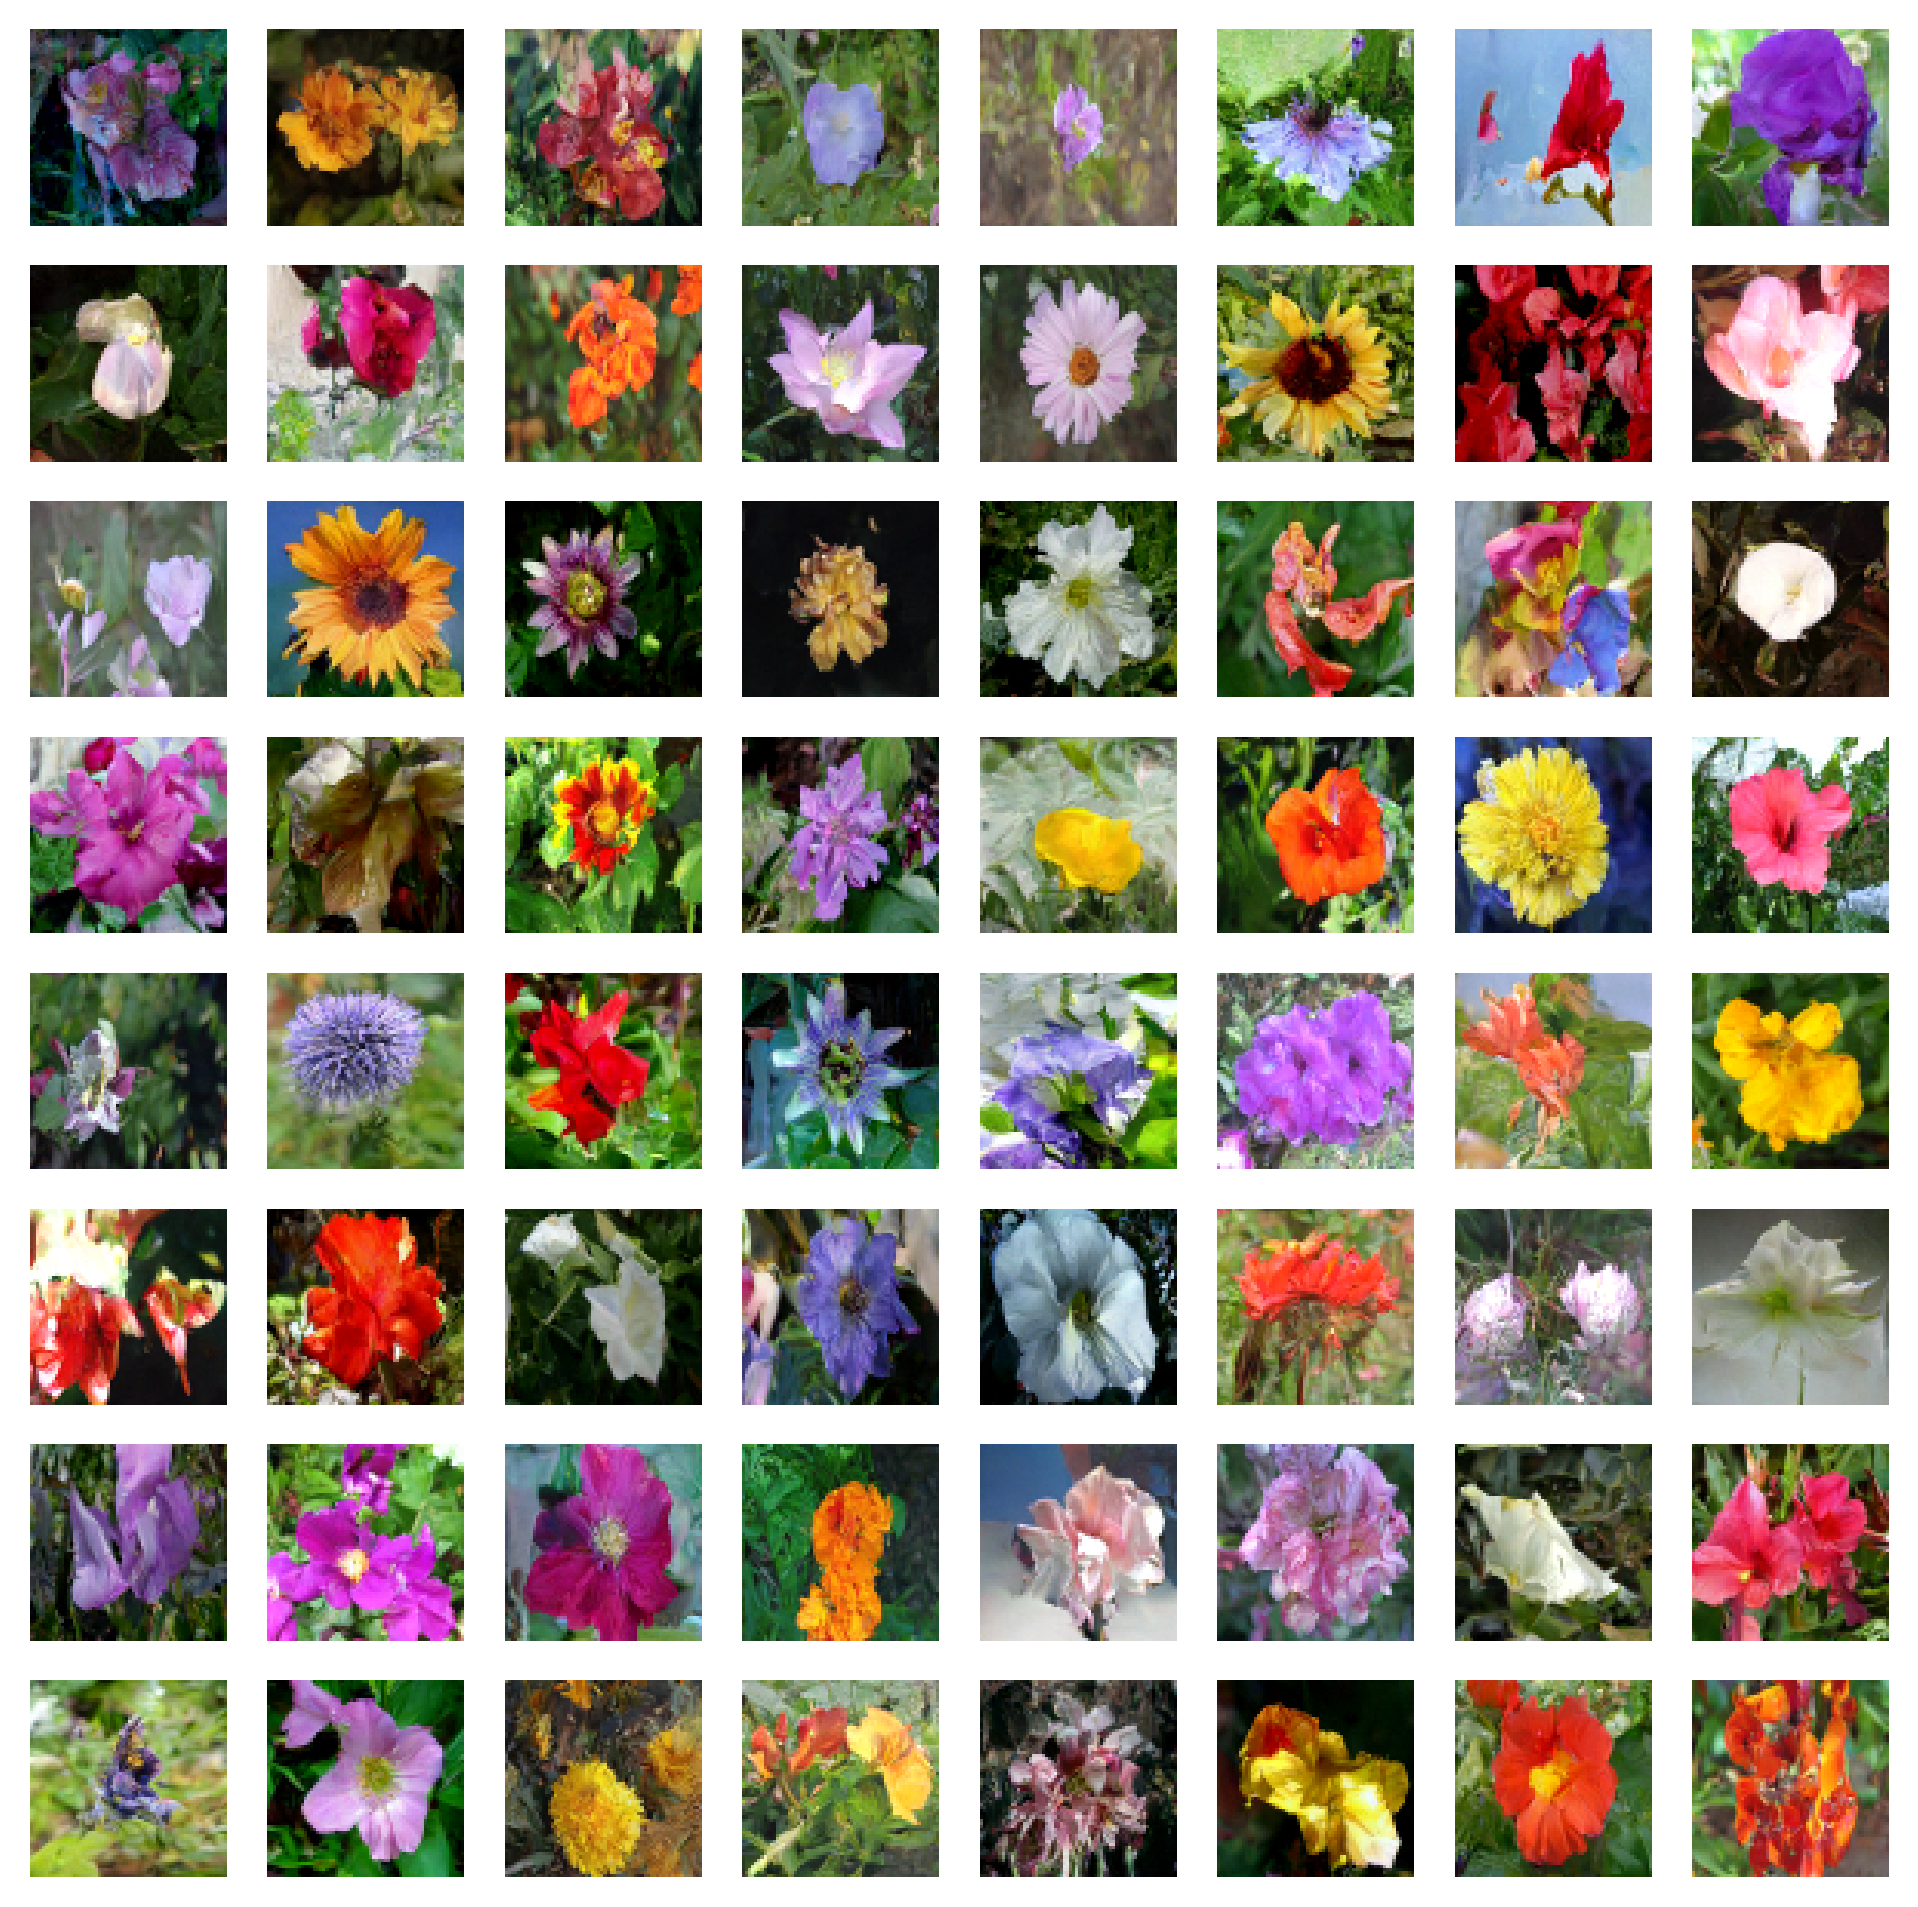

In [25]:
sampler = RK4Sampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=6, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


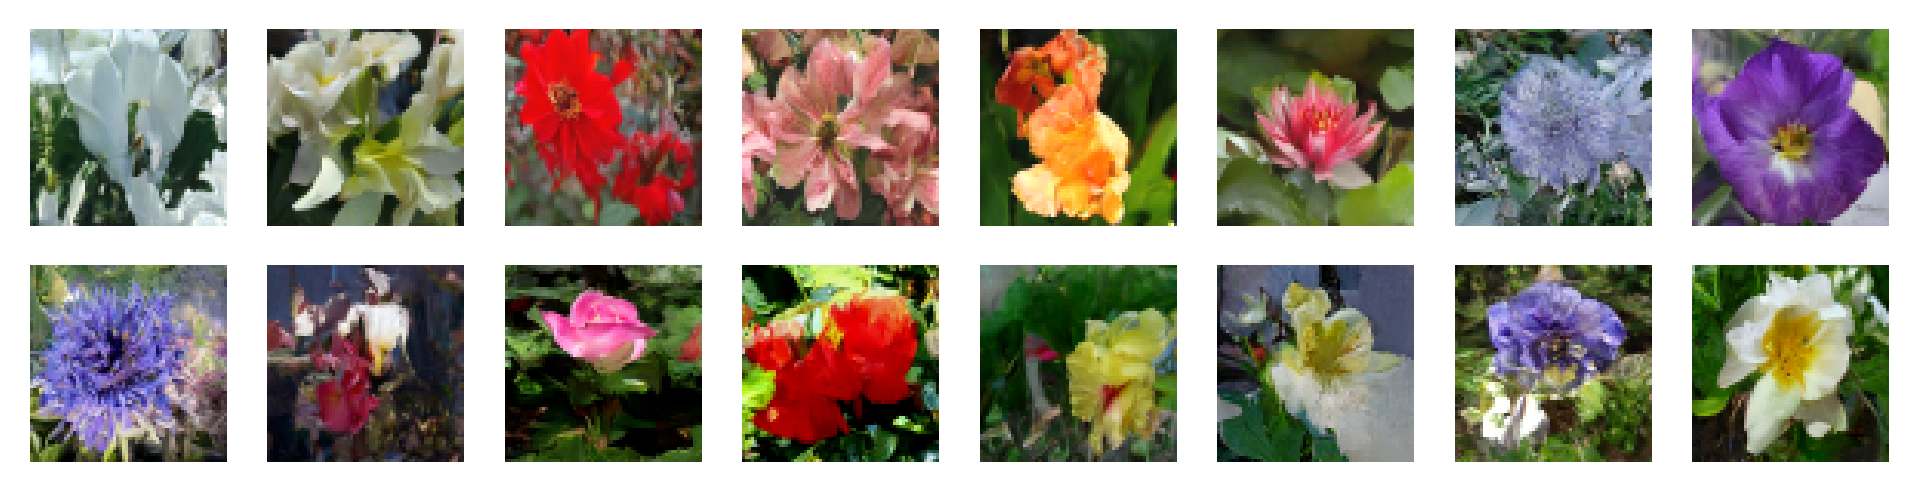

In [39]:
sampler = HeunSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=16, diffusion_steps=50, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


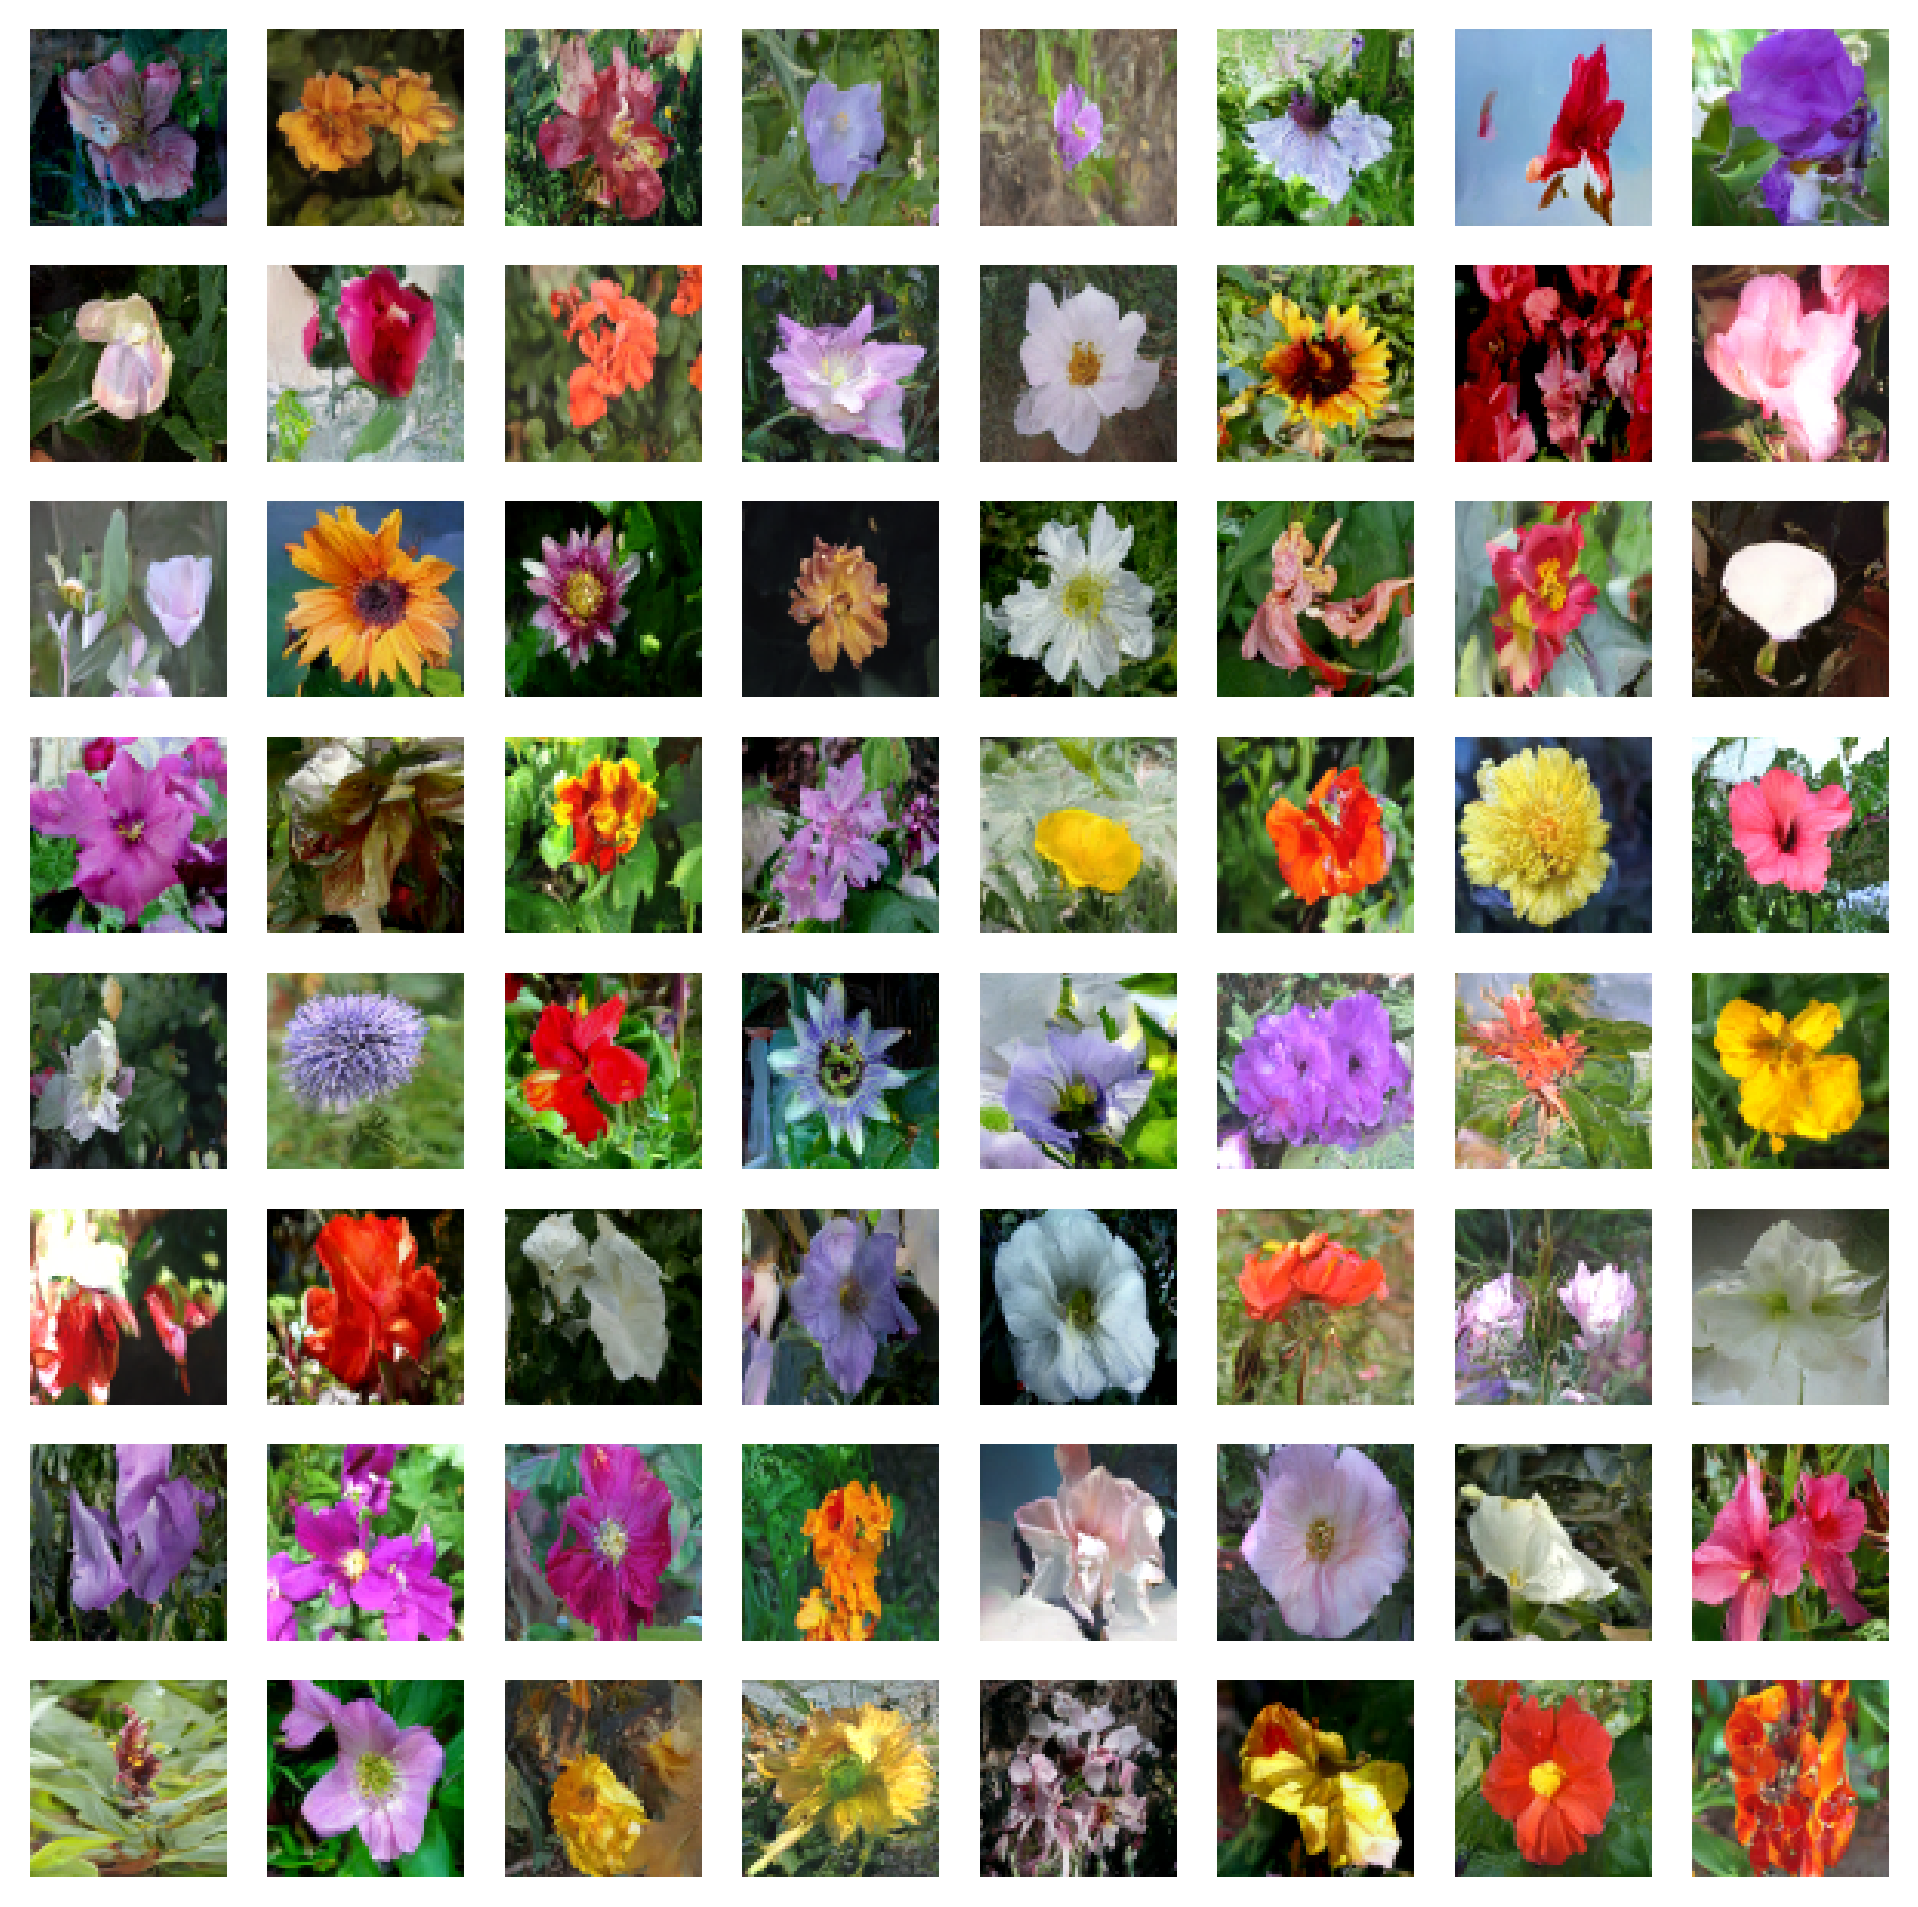

In [36]:
sampler = HeunSampler(trainer.model, trainer.best_state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=20, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


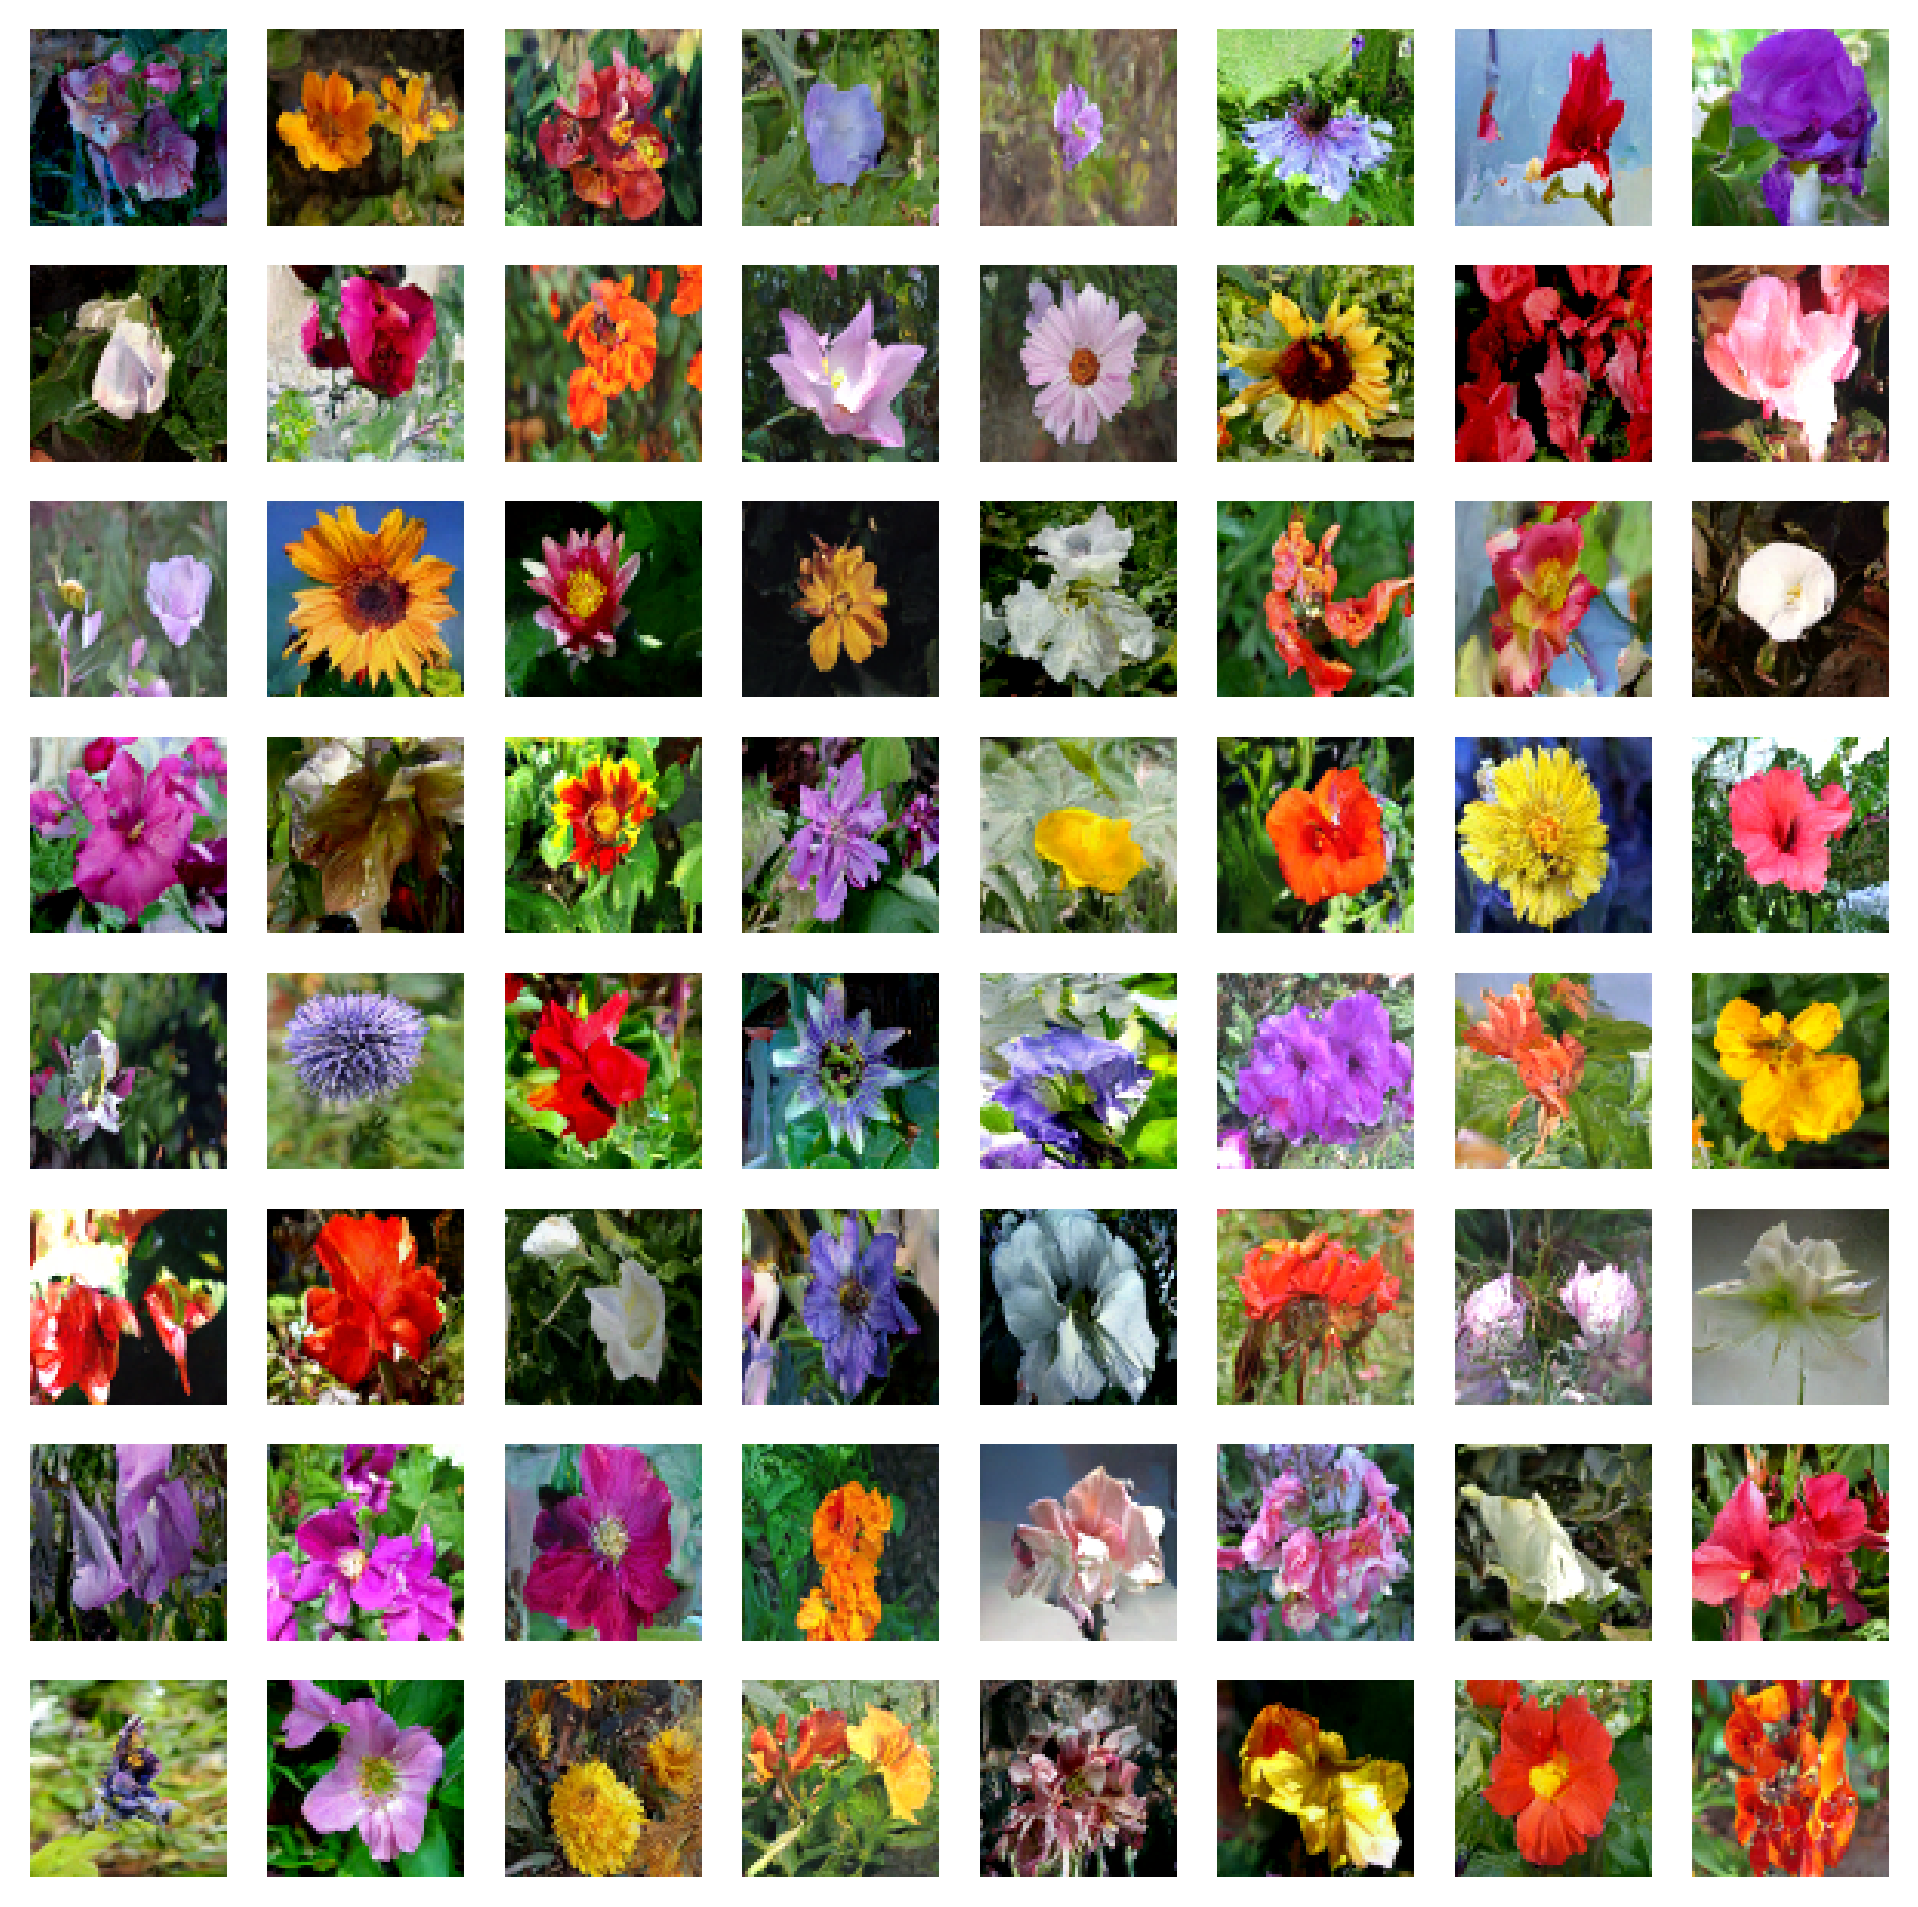

In [24]:
sampler = HeunSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=10, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


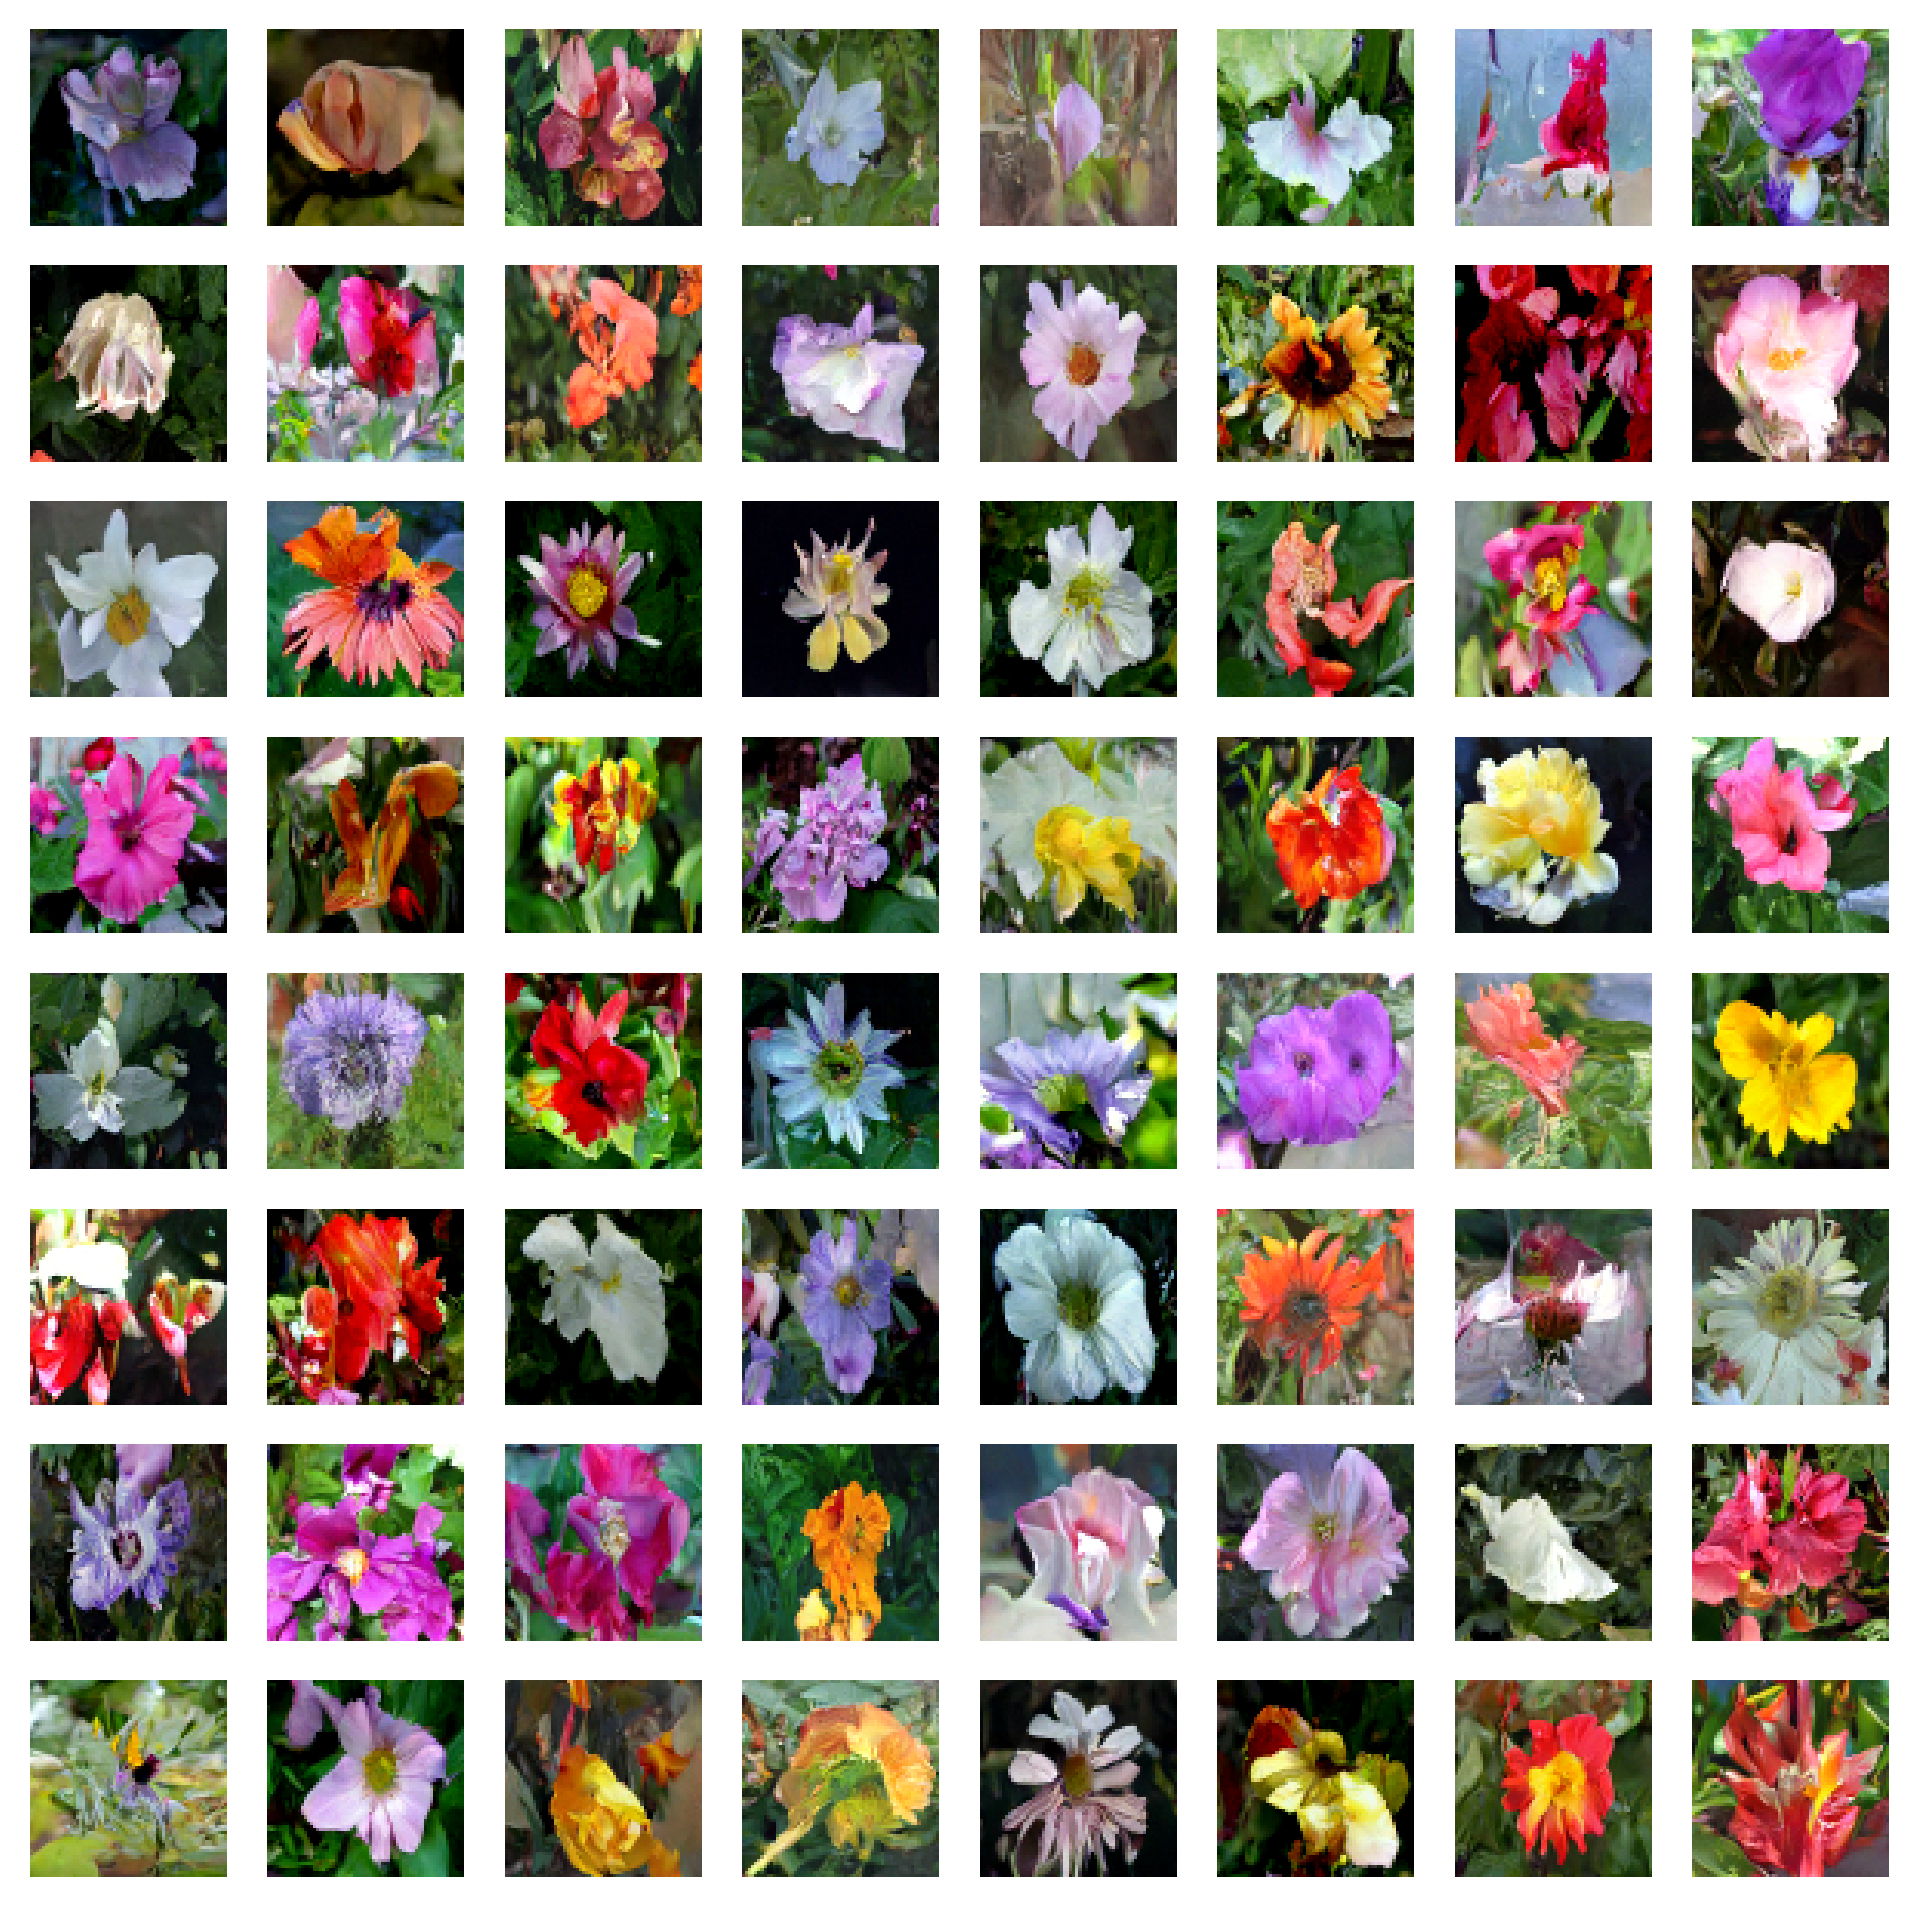

In [253]:
sampler = HeunSampler(trainer.model, trainer.state.ema_params, karas_ve_schedule, model_output_transform=trainer.model_output_transform)
samples = sampler.generate_images(num_images=64, diffusion_steps=10, start_step=1000, end_step=0, priors=None)
plotImages(samples, dpi=300)